In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [2]:
NL_c = 0.01
EmitStr = ['7','14','28']
nEmit = len(EmitStr)
Emit  = [float(emit)*1.0e-9/NL_c**2 for emit in EmitStr]
tunex = 1.0-0.8538658
_x = 2
_xSTR = 'Y'
q_max = 20.0
k_max = 0.1
dw_dI = 2*np.pi*0.65346402
legend = [emit + ' nm' for emit in EmitStr]

In [3]:
def GaussDist(x):
    return np.exp(-x**2/2.0)/np.sqrt(2.0*np.pi)
Q = np.linspace(-q_max,q_max,2048)
histData = GaussDist(Q)
dq = Q[1]-Q[0]

# Centroid from tracking

In [4]:
cData=[]
Xi0  =[]
nMax =[]
i=0
for i in range(nEmit):
    cData.append(np.load(_xSTR+'.ent.emit'+EmitStr[i]+'nm.npy'))
    Xi0.append(cData[i][0])
    print(np.abs(Xi0[i]))
    cData[i] = cData[i]/cData[i][0]

0.12361900924114845
0.12359979222445064
0.1236396606998185


# Compare cData Time Domain

### as it is

In [5]:
cDataModel = [0]*nEmit
for i in range(nEmit):
    T = len(cData[i])
    cDataModel[i]=np.zeros(T,dtype=np.complex)
    for t in range(T):
        cDataModel[i][t] = np.sum(histData*np.exp(-1j*t*Emit[i]**0.5*Q*np.abs(Xi0[i])*dw_dI)*dq)*np.exp(-2j*np.pi*tunex*t)    
    cDataModel[i] = cDataModel[i]/cDataModel[i][0]

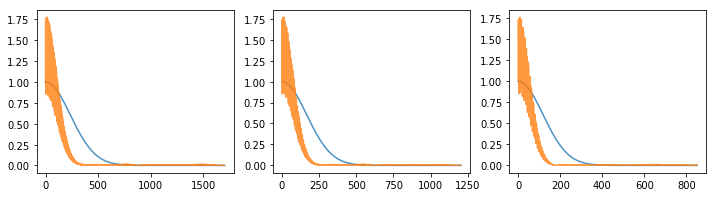

In [6]:
plt.figure(figsize=(nEmit*4,3))
for i in range(nEmit):
    plt.subplot(1,nEmit,i+1)
    plt.plot(np.abs(cDataModel[i]),alpha=0.8)
    plt.plot(np.abs(cData[i]),     alpha=0.8)

### effort to find better $\xi_0$ value

plt.figure(figsize=(nEmit*4,3))
for i in range(nEmit):
    plt.subplot(1,nEmit,i+1)
    plt.plot(np.abs(cData[i][:10]),alpha=0.8)
    
for i in range(len(Emit)):
    xMean = np.mean(np.abs(cData[i][:10]))
    iMean=np.argmin(np.abs(np.abs(cData[i][:10])-xMean))
    Xi0[i]=Xi0[i]*cData[i][iMean]
    print(np.abs(Xi0[i]))
    cData[i]=cData[i][iMean:]/cData[i][iMean]

cDataModel = [0]*nEmit
for i in range(nEmit):
    T = len(cData[i])
    cDataModel[i]=np.zeros(T,dtype=np.complex)
    for t in range(T):
        cDataModel[i][t] = np.sum(histData*np.exp(-1j*t*Emit[i]**0.5*Q*np.abs(Xi0[i])*dw_dI)*dq)*np.exp(-2j*np.pi*tunex*t)    
    cDataModel[i] = cDataModel[i]/cDataModel[i][0]

plt.figure(figsize=(nEmit*4,3))
for i in range(nEmit):
    plt.subplot(1,nEmit,i+1)
    plt.plot(np.abs(cDataModel[i]),alpha=0.8)
    plt.plot(np.abs(cData[i]),     alpha=0.8)

# Compare cData Freq Domain

In [7]:
nSample = 2048
K = np.linspace(-k_max,k_max,nSample)
Tune = [0]*len(Emit)
Amp  = [0]*len(Emit)
for i in range(len(Emit)):
    T = len(cData[i])
    Amp[i] = np.zeros(nSample,dtype=np.complex)
    Tune[i] = tunex + K
    for k in range(nSample):
        Amp[i][k] = np.sum(cData[i]*np.exp(2j*np.pi*Tune[i][k]*np.arange(0,T)))
    Amp[i] = Amp[i]*Emit[i]**0.5

In [8]:
Q = Q
histData = histData*np.pi/np.abs(Xi0[0]*dw_dI)

### as it is 

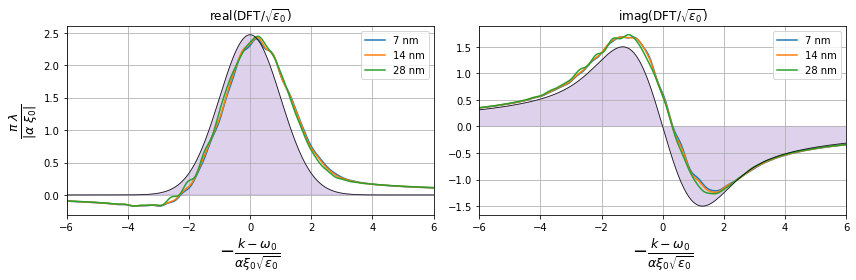

In [9]:
from scipy.signal import hilbert
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for i in range(len(Emit)):
    plt.plot(-2*np.pi*K/(Emit[i]**0.5*np.abs(Xi0[i])*dw_dI)/2.0,np.real(Amp[i])*1.6)
plt.plot(Q,histData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q, 0, histData,color='C4',alpha=0.3)
plt.xlim(-6.0,6.0)
plt.xlabel(r'$-\frac{k-\omega_0}{\alpha \xi_0 \sqrt{\epsilon_0}}$',fontsize=18);
plt.ylabel(r'$\frac{\pi\,\,\lambda}{|\alpha\,\,\xi_0|}$',fontsize=18);
plt.title('real(DFT$/\sqrt{\epsilon_0}$)',fontsize=12);
plt.legend(legend)
plt.grid()

hilbertData = -np.imag(hilbert(histData))
plt.subplot(1,2,2)
for i in range(len(Emit)):
    plt.plot(-2*np.pi*K/(Emit[i]**0.5*np.abs(Xi0[i])*dw_dI)/2.0,np.imag(Amp[i])*1.6)
plt.plot(Q,hilbertData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q, 0, hilbertData,color='C4',alpha=0.3)
plt.xlabel(r'$-\frac{k-\omega_0}{\alpha \xi_0 \sqrt{\epsilon_0}}$',fontsize=18);
plt.xlim(-6.0,6.0)
plt.title('imag(DFT$/\sqrt{\epsilon_0}$)',fontsize=12);
plt.legend(legend)
plt.grid()
plt.tight_layout()

## artificial fitting <--- 1.6 factor on amplitude, 2.0 on spectral width and on -0.28 on phase shift 

In [10]:
K = np.linspace(-k_max,k_max,nSample)
for i in range(len(Emit)):
    T = len(cData[i])
    Amp[i] = np.zeros(nSample,dtype=np.complex)
    Tune[i] = tunex + K
    for k in range(nSample):
        Amp[i][k] = np.sum(cData[i]*np.exp(2j*np.pi*Tune[i][k]*np.arange(0,T)))
    Amp[i] = Amp[i]*Emit[i]**0.5

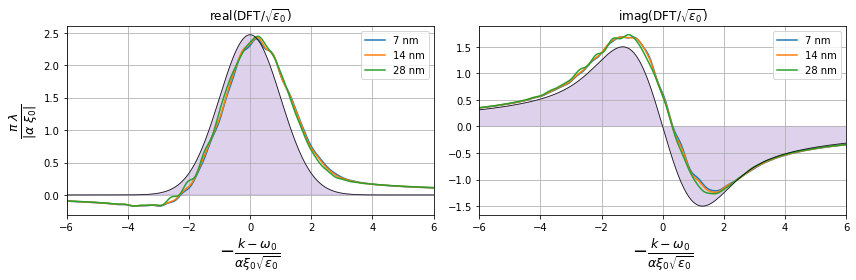

In [11]:
from scipy.signal import hilbert
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for i in range(len(Emit)):
    plt.plot(-2*np.pi*K/(Emit[i]**0.5*np.abs(Xi0[i])*dw_dI)/2.0,np.real(Amp[i])*1.6)
plt.plot(Q,histData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q, 0, histData,color='C4',alpha=0.3)
plt.xlim(-6.0,6.0)
plt.xlabel(r'$-\frac{k-\omega_0}{\alpha \xi_0 \sqrt{\epsilon_0}}$',fontsize=18);
plt.ylabel(r'$\frac{\pi\,\,\lambda}{|\alpha\,\,\xi_0|}$',fontsize=18);
plt.title('real(DFT$/\sqrt{\epsilon_0}$)',fontsize=12);
plt.legend(legend)
plt.grid()

hilbertData = -np.imag(hilbert(histData))
plt.subplot(1,2,2)
for i in range(len(Emit)):
    plt.plot(-2*np.pi*K/(Emit[i]**0.5*np.abs(Xi0[i])*dw_dI)/2.0,np.imag(Amp[i])*1.6)
plt.plot(Q,hilbertData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q, 0, hilbertData,color='C4',alpha=0.3)
plt.xlabel(r'$-\frac{k-\omega_0}{\alpha \xi_0 \sqrt{\epsilon_0}}$',fontsize=18);
plt.xlim(-6.0,6.0)
plt.title('imag(DFT$/\sqrt{\epsilon_0}$)',fontsize=12);
plt.legend(legend)
plt.grid()
plt.tight_layout()